# 📊 ETL e Análise de Dados de Biometria de Tilápias

Este notebook tem como objetivo realizar o processo completo de ETL (Extração, Transformação e Carga), análise estatística e visualização interativa dos dados de biometria de tanques de produção de tilápia.

---

## 📦 1. Importação de Bibliotecas

Foram utilizadas bibliotecas como:

- `pandas` para manipulação de dados
- `plotly.express` para gráficos interativos
- `ipywidgets` para interfaces de seleção dinâmica
- `glob` e `os` para leitura de arquivos em lote

---

## ⚙️ 2. ETL — Extração e Tratamento dos Arquivos de Biometria

Diversos arquivos `.xlsx` foram processados de forma automatizada. O pipeline:

- Ler todos os arquivos de um diretório específico
- Identificar e extrair informações da aba `"01 (2)"`
- Padronizar os nomes de colunas
- Converter datas e valores numéricos
- Armazenar os dados em um único DataFrame consolidado (`df_biometria_final`)

---

## 📈 3. Análises Estatísticas

Foi conduzida uma sequência de análises sobre os dados de biometria:

- 📌 Estatísticas descritivas: média, desvio padrão, mínimo e máximo de peso, biomassa e número de peixes
- 📊 Avaliação da quantidade de biometrias por tanque
- 🔍 Cálculo do **GMD (Ganho Médio Diário)** entre duas medições consecutivas
- 📉 Ranking dos tanques por performance de crescimento
- 🧪 Identificação de outliers via boxplots

---

## 📊 4. Visualização Interativa

Uma função interativa `plot_peso_biometria()` foi criada com:

- Um dropdown para selecionar o tanque
- Um gráfico de linha com:
  - Eixo X: data da biometria
  - Eixo Y: peso médio atual dos peixes
- Layout otimizado com:
  - Fundo branco
  - Linhas e texto escuros
  - Estilo limpo e responsivo para relatórios

---

## ✅ Conclusão

O notebook permite a automatização da ingestão de dados de biometria, análise de desempenho por tanque e visualização intuitiva do crescimento ao longo do tempo. É uma ferramenta prática e eficaz para monitoramento técnico e tomada de decisão em piscicultura.



In [15]:
import pandas as pd
from glob import glob
import os
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display

In [12]:
import os
import pandas as pd
from glob import glob

def load_biometria_data(path_folder="biometria"):
    all_files = glob(os.path.join(path_folder, "*.xlsx"))
    all_data = []

    for file in all_files:
        try:
            xls = pd.ExcelFile(file)

            # Verifica se a aba existe
            if "01 (2)" not in xls.sheet_names:
                print(f"⚠️ Aba '01 (2)' não encontrada em: {file}")
                continue

            df = xls.parse("01 (2)", header=12)

            # Limpar nomes de colunas
            df.columns = [str(col).strip().upper().replace(" ", "_") for col in df.columns]

            df["FILENAME"] = os.path.basename(file)

            if "ULTIMA_BIOMETRIA" in df.columns:
                df["DATA_BIOMETRIA"] = pd.to_datetime(df["ULTIMA_BIOMETRIA"], errors="coerce")
            else:
                df["DATA_BIOMETRIA"] = pd.NaT

            # Mapear colunas obrigatórias
            cols_to_keep = {
                "UNID.PRODUÇÃO": "TANQUE",
                "PESO_ATUAL": "PESO_ATUAL",
                "Nº_DE_PEIXES_ATUAL": "N_PEIXES_ATUAL",
                "BIOM_ATUAL": "BIOMASSA_ATUAL"
            }

            # Verifica se todas as colunas estão presentes
            missing_cols = [col for col in cols_to_keep if col not in df.columns]
            if missing_cols:
                print(f"⚠️ Colunas ausentes em {file}: {missing_cols}")
                continue

            temp_df = df[list(cols_to_keep.keys())].rename(columns=cols_to_keep)
            temp_df["DATA_BIOMETRIA"] = df["DATA_BIOMETRIA"]
            temp_df["FILENAME"] = df["FILENAME"]

            temp_df = temp_df.dropna(subset=["TANQUE", "DATA_BIOMETRIA", "PESO_ATUAL"])
            all_data.append(temp_df)

        except Exception as e:
            print(f"⚠️ Erro ao ler {file}: {e}")

    if all_data:
        return pd.concat(all_data, ignore_index=True)
    else:
        return pd.DataFrame()


In [14]:
# Load and preview final DataFrame
df_biometria_final = load_biometria_data()
df_biometria_final.head(20)

C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: '01 (2)'!$4:$30.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: '01 (2)'!$4:$30.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\reader\workbook.py:118: UserWarning: Print area cannot be set to Defined name: '01 (2)'!$4:$32.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")
C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Pyth

,TANQUE,PESO_ATUAL,N_PEIXES_ATUAL,BIOMASSA_ATUAL,DATA_BIOMETRIA,FILENAME
0,TANQUE 02,823.0,11117.0,9149.291,2025-01-28,TILAPIA - 01-2025 - BIOMETRIA ENGORDA D. FRIDA...
1,TANQUE 03,836.0,7597.0,6351.092,2025-01-28,TILAPIA - 01-2025 - BIOMETRIA ENGORDA D. FRIDA...
2,TANQUE 04,858.0,5915.0,5075.070,2025-01-28,TILAPIA - 01-2025 - BIOMETRIA ENGORDA D. FRIDA...
3,TANQUE 05,916.0,22040.0,20188.640,2025-01-28,TILAPIA - 01-2025 - BIOMETRIA ENGORDA D. FRIDA...
4,TANQUE 06,785.0,20000.0,15700.000,2025-01-28,TILAPIA - 01-2025 - BIOMETRIA ENGORDA D. FRIDA...
5,TANQUE 07,680.0,21522.0,14634.960,2025-01-28,TILAPIA - 01-2025 - BIOMETRIA ENGORDA D. FRIDA...
6,TANQUE 08,677.0,20416.0,13821.632,2025-01-28,TILAPIA - 01-2025 - BIOMETRIA ENGORDA D. FRIDA...
7,TANQUE 09,519.0,25850.0,13416.150,2025-01-28,TILAPIA - 01-2025 - BIOMETRIA ENGORDA D. FRIDA...
8,TANQUE 10,279.0,58844.0,16417.476,2025-01-28,TILAPIA - 01-2025 - BIOMETRIA ENGORDA D. FRIDA...
9,TANQUE 11,607.0,20000.0,12140.000,2025-01-28,TILAPIA - 01-2025 - BIOMETRIA ENGORDA D. FRIDA...


### Cleaning - Higienização dos dados do dataframe

In [18]:
df_biometria_final["DATA_BIOMETRIA"] = pd.to_datetime(df_biometria_final["DATA_BIOMETRIA"])
df_biometria_final["PESO_ATUAL"] = pd.to_numeric(df_biometria_final["PESO_ATUAL"], errors="coerce")
df_biometria_final["N_PEIXES_ATUAL"] = pd.to_numeric(df_biometria_final["N_PEIXES_ATUAL"], errors="coerce")
df_biometria_final["BIOMASSA_ATUAL"] = pd.to_numeric(df_biometria_final["BIOMASSA_ATUAL"], errors="coerce")


### 📌 Estatísticas descritivas: média, desvio padrão, mínimo e máximo de peso, biomassa e número de peixes

In [19]:
df_biometria_final.describe()

,PESO_ATUAL,N_PEIXES_ATUAL,BIOMASSA_ATUAL,DATA_BIOMETRIA
count,131.000000,131.000000,131.000000,131
mean,521.829466,22173.725191,10334.168536,2024-11-19 06:57:42.595419904
min,0.660000,2709.000000,5.957160,2024-06-20 00:00:00
25%,303.000000,20000.000000,6107.988000,2024-08-31 00:00:00
50%,519.000000,21000.000000,10584.180000,2024-12-02 00:00:00
75%,778.000000,22300.000000,14130.020500,2025-02-08 12:00:00
max,979.000000,58844.000000,21224.520000,2025-03-31 00:00:00
std,257.914097,10297.981272,5096.103866,NaN


### 📊 Avaliação da quantidade de biometrias por tanque

In [40]:
avaliacoes_por_tanque = df_biometria_final.groupby("TANQUE").size().sort_values(ascending=False)
print(avaliacoes_por_tanque)

TANQUE
TANQUE 03    10
TANQUE 04    10
TANQUE 05    10
TANQUE 06    10
TANQUE 07    10
TANQUE 08    10
TANQUE 09    10
TANQUE 02    10
TANQUE 11    10
TANQUE 12    10
TANQUE 13     9
TANQUE 01     5
TANQUE 10     5
TANQUE 14     4
TANQUE 15     3
TANQUE 16     3
TANQUE 17     1
TANQUE 18     1
dtype: int64


### 🔍 Cálculo do **GMM (Ganho Médio Mensal)** entre duas medições consecutivas

In [41]:
peso_medio_por_tanque = df_biometria_final.groupby("TANQUE")["PESO_ATUAL"].mean().sort_values(ascending=False)
print(peso_medio_por_tanque) 


TANQUE
TANQUE 05    773.500000
TANQUE 04    764.100000
TANQUE 03    741.100000
TANQUE 01    741.000000
TANQUE 02    732.900000
TANQUE 06    656.800000
TANQUE 07    561.800000
TANQUE 08    537.100000
TANQUE 11    401.700000
TANQUE 09    374.900000
TANQUE 13    331.777778
TANQUE 12    269.466000
TANQUE 10    229.000000
TANQUE 14    217.250000
TANQUE 15    208.000000
TANQUE 17    196.000000
TANQUE 18    187.000000
TANQUE 16    171.333333
Name: PESO_ATUAL, dtype: float64


### 🔍 Cálculo do **GMM (Ganho Médio Mensal)** entre duas medições consecutivas

In [1]:
df_biometria_final = df_biometria_final.sort_values(["TANQUE", "DATA_BIOMETRIA"])
df_biometria_final["PESO_ANTERIOR"] = df_biometria_final.groupby("TANQUE")["PESO_ATUAL"].shift(1)
df_biometria_final["DATA_ANTERIOR"] = df_biometria_final.groupby("TANQUE")["DATA_BIOMETRIA"].shift(1)

df_biometria_final["DIAS_ENTRE_BIOMETRIAS"] = (df_biometria_final["DATA_BIOMETRIA"] - df_biometria_final["DATA_ANTERIOR"]).dt.days
df_biometria_final["GMD"] = (df_biometria_final["PESO_ATUAL"] - df_biometria_final["PESO_ANTERIOR"]) / df_biometria_final["DIAS_ENTRE_BIOMETRIAS"]
print(df_biometria_final["GMD"])


NameError: name 'df_biometria_final' is not defined

### 📉 Ranking dos tanques por performance de crescimento

In [43]:
gmd_por_tanque = df_biometria_final.groupby("TANQUE")["GMD"].mean().sort_values(ascending=False)
print(gmd_por_tanque)


TANQUE
TANQUE 01    2.911559
TANQUE 02    2.638046
TANQUE 05    2.563616
TANQUE 11    2.465138
TANQUE 07    2.250820
TANQUE 06    2.200235
TANQUE 08    1.860468
TANQUE 04    1.724592
TANQUE 12    1.703829
TANQUE 03    1.701110
TANQUE 09    1.637578
TANQUE 16    1.142857
TANQUE 13    1.120058
TANQUE 10    1.101957
TANQUE 15    0.877463
TANQUE 14    0.809353
TANQUE 17         NaN
TANQUE 18         NaN
Name: GMD, dtype: float64


### 🧪 Identificação de outliers via boxplots


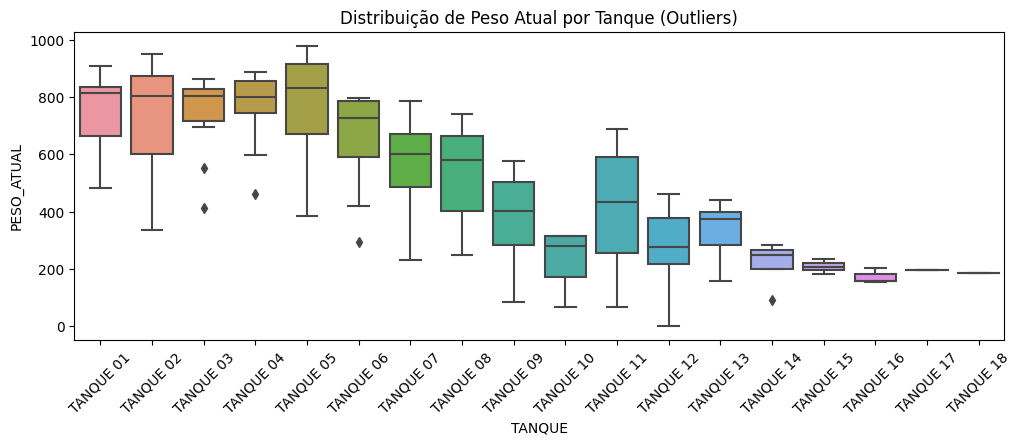

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
sns.boxplot(data=df_biometria_final, x="TANQUE", y="PESO_ATUAL")
plt.xticks(rotation=45)
plt.title("Distribuição de Peso Atual por Tanque (Outliers)")
plt.show()

In [34]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets

def plot_peso_biometria(df_biom):
    # Garantir formato de data
    df_biom["DATA_BIOMETRIA"] = pd.to_datetime(df_biom["DATA_BIOMETRIA"], errors="coerce")

    # Dropdown de tanques
    tanques = sorted(df_biom["TANQUE"].dropna().unique())
    dropdown = widgets.Dropdown(options=tanques, description='Tanque:', layout=widgets.Layout(width='50%'))

    # Função que atualiza o gráfico
    def update_plot(tanque):
        df_tanque = df_biom[df_biom["TANQUE"] == tanque].sort_values("DATA_BIOMETRIA")

        fig = px.line(
            df_tanque,
            x="DATA_BIOMETRIA",
            y="PESO_ATUAL",
            title=f"Evolução do Peso Atual - {tanque}",
            markers=True,
            labels={
                "DATA_BIOMETRIA": "Data da Biometria",
                "PESO_ATUAL": "Peso Médio (g)"
            }
        )

        fig.update_traces(
            line=dict(width=3, color="black"),
            marker=dict(size=8, color="darkblue", symbol="circle")
        )

        fig.update_layout(
            template="plotly_white",
            title_font=dict(size=20, color='black'),
            font=dict(color='black'),
            title_x=0.5,
            plot_bgcolor='white',
            paper_bgcolor='white',
            xaxis=dict(
                title="Data",
                showgrid=True,
                gridcolor='lightgray',
                linecolor='black',
                tickfont=dict(color='black'),
                titlefont=dict(color='black'),
                tickformat='%b/%Y'
            ),
            yaxis=dict(
                title="Peso Atual (g)",
                showgrid=True,
                gridcolor='lightgray',
                linecolor='black',
                tickfont=dict(color='black'),
                titlefont=dict(color='black')
            ),
            margin=dict(t=60, l=60, r=40, b=60)
        )

        fig.show()

    widgets.interact(update_plot, tanque=dropdown)


In [ ]:
df_biom = load_biometria_data("biometria")
plot_peso_biometria(df_biom)

C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\reader\workbook.py:118: UserWarning:

Print area cannot be set to Defined name: '01 (2)'!$4:$30.

C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\reader\workbook.py:118: UserWarning:

Print area cannot be set to Defined name: '01 (2)'!$4:$30.

C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\reader\workbook.py:118: UserWarning:

Print area cannot be set to Defined name: '01 (2)'!$4:$32.

C:\Users\crist\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\openpyxl\reader\workbook.py:118: UserWarning:

Print area cannot be set to Defined name: '01 (2)'!$4:$28.

C:\Users\crist\A

interactive(children=(Dropdown(description='Tanque:', options=('TANQUE 01', 'TANQUE 02', 'TANQUE 03', 'TANQUE …